In [130]:
import importlib.util
import os
import json
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from simpleRegArchitecture import SimpleNet

load_dotenv() 

True

In [131]:
NUM_BINS = 5

config_file_path = os.getenv('CONFIG_FILE_PATH')
print(config_file_path)
with open(config_file_path, "r") as f:
    config = json.load(f)

#Load in the networks
output_dir = config.get("output_dir")
loaded_state_dict = torch.load(f'{output_dir}/trainedNetworks.pt')

#create new instantiations to contain the saved networks
num_networks = config.get("num_networks")
networks = []
for n in range(num_networks):
    networks.append(SimpleNet())

for i, network in enumerate(networks):
    state_dict_key = f'network_{i}'
    network.load_state_dict(loaded_state_dict[state_dict_key])




/Users/simoncole/seniorDesign/Large-Scale-Design-and-Analysis-of-Neural-Networks/config.json


In [132]:
def getMinOrMax(networks, getMin):
    """
    Parameters:
    - networks: an array of trained pytorch networks where the layers are nn.Linear
    - getMin: a boolean indicating wheter to get the min or max
    Outputs: the minimum or maximum weight in some array of neural networks
    """
    weights = []
    for network in networks:
        for layer in network.children():
            if isinstance(layer, nn.Linear):
                #.cpu moves the tensor from the gpu to cpu if it is there in order to use .numpy()
                layer_weights = layer.weight.data.cpu().numpy().flatten()
                weights.extend(layer_weights)
    if getMin:
        return min(weights) - 1e-6 #small adjustment to account for floating point rounding error, issue occured with getting the upper bound of the max bin
    else:
        return max(weights) + 1e-6

min_weight = getMinOrMax(networks, True)
max_weight = getMinOrMax(networks, False)
print(min_weight)
print(max_weight)


-1.0972892509231567
1.0222512946853637


In [133]:
layer_weight_distributions = []
layer_bin_ranges = []
network_fc_indices = []
#for each fully connected layer, create matrix of shape (N, M, B) where
#N = num neurons in layer
#M = num neurons in previous layer
#B = number of bins
#generate an array of bin edges based on min and max of the first network(for now)
    
layers = networks[0].children()
for index, layer in enumerate(layers):
    if isinstance(layer, nn.Linear):
        #for each layer make an array of shape (num of neurons in layer, num of inputs to layer, num of bins)
        network_fc_indices.append(index)
        layer_shape = layer.weight.shape
        layer_weight_distributions.append(np.zeros((NUM_BINS,) + layer_shape, dtype=int))
        #TODO: get clarity as to whether min and max should be for each layer or for entire network
        #subtract 1 to make 0-indexed
        bin_edges = np.histogram_bin_edges(a=[], bins=(NUM_BINS), range=(min_weight, max_weight))
        layer_bin_ranges.append(bin_edges)
        
#Generate for each layer a matrix of network, row, column matrix
network_weights = []
for index, layer_index in enumerate(network_fc_indices):
    network_weights_per_layer = []
    for network in networks:
        net_layers = list(network.children())
        network_weights_per_layer.append(net_layers[layer_index].weight.data.numpy())
    network_weights.append(network_weights_per_layer)

# print(layer_weight_distributions)
print(layer_bin_ranges[0])
#print the first weight of the first fully connected layer of the first network
print(network_weights[0][0][0][0])

[-1.09728925 -0.67338114 -0.24947303  0.17443508  0.59834319  1.02225129]
-0.34732863


In [134]:
#iterating over each layer
for layer_num, layer_distribution in enumerate(layer_weight_distributions):
    #iterate over all the weights in a layer and increment their corresponding index in the bin ranges to the 3D array 
    #select the first bin for iteration, could select any
    for i, row in enumerate(layer_distribution[0]):
        for j, weight_count in enumerate(row):
            #get the matching bin for the value of the weight
            #for this weight position, iterate over each network and select the layer you're already in
            #then get the bin for that weight and increment the corresponding bin and position
            for network in network_weights[layer_num]:
                #includes the left bin edge and excludes the right
                weight = network[i][j]
                #subtract 1 to 0 index
                corresponding_bin = np.digitize(weight, layer_bin_ranges[layer_num], right=False) - 1
                if corresponding_bin >= 5 or corresponding_bin <= -1:
                    print(weight)
                    print(corresponding_bin)
                layer_weight_distributions[layer_num][corresponding_bin][i][j] += 1

print(layer_weight_distributions)

[array([[[ 73,  27],
        [ 88,  26],
        [ 86,  38],
        [ 83,  30],
        [103,  20],
        [ 79,  23],
        [101,  31],
        [ 81,  33],
        [105,  31],
        [ 81,  38]],

       [[253, 272],
        [244, 296],
        [248, 293],
        [239, 320],
        [270, 281],
        [233, 275],
        [234, 305],
        [269, 264],
        [236, 282],
        [251, 293]],

       [[281, 348],
        [277, 352],
        [301, 349],
        [279, 301],
        [275, 324],
        [288, 354],
        [291, 306],
        [289, 336],
        [293, 316],
        [292, 325]],

       [[226, 251],
        [225, 259],
        [223, 244],
        [234, 265],
        [224, 284],
        [236, 278],
        [231, 272],
        [213, 283],
        [234, 301],
        [228, 271]],

       [[167, 102],
        [166,  67],
        [142,  76],
        [165,  84],
        [128,  91],
        [164,  70],
        [143,  86],
        [148,  84],
        [132,  70],
        [14

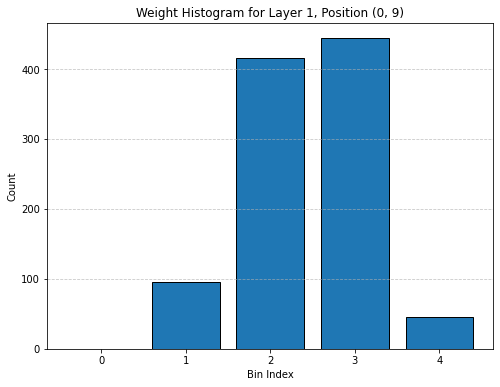

In [154]:
def plot_weight_bins(weight_distributions, layer, weight_position):
    """
    Parameters:
    - weight_distributions: weight counts in the form (layer, bin, i, j) where i and j represent the postion of the weight
    - layer: Index of the layer to plot (0-indexed).
    - weight_position: Tuple indicating the row and column of the weight in the layer.
    """
    weight_distribution = weight_distributions[layer][:, weight_position[0], weight_position[1]]
    
    num_bins = len(weight_distribution)
    
    plt.figure(figsize=(8, 6))
    plt.bar(range(num_bins), weight_distribution, width=0.8, align='center', edgecolor='black')
    plt.xlabel('Bin Index')
    plt.ylabel('Count')
    plt.title(f'Weight Histogram for Layer {layer}, Position {weight_position}')
    plt.xticks(range(num_bins))  # Set x-ticks to match bin indices
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# print(layer_weight_distributions[1][:, 0])
# print(layer_weight_distributions[1][:, 0, 0])
# plot_weight_bins(layer_weight_distributions, layer=0, weight_position=(1, 0))
# neuron 10 in layer 1 coming from input neuron 2
plot_weight_bins(layer_weight_distributions, layer=1, weight_position=(0, 9))
